## Unsupervised Sentiment Analysis using VADER

In [1]:
# === Imports & Setup ===
# If running in a fresh environment, install packages first (uncomment):
# !pip install nltk scikit-learn seaborn matplotlib tqdm

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.sentiment import SentimentIntensityAnalyzer

# Download needed NLTK data (safe to run multiple times)
nltk.download('movie_reviews', quiet=True)
nltk.download('vader_lexicon', quiet=True)

# Reproducibility
random_seed = 94
np.random.seed(random_seed)

VADER Sentiment Analysis - Unsupervised Approach


[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/chanhengmenh/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/chanhengmenh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# === Load NLTK movie_reviews dataset ===
from nltk.corpus import movie_reviews

# Extract texts and labels (pos/neg)
texts = [movie_reviews.raw(fileid) for fileid in movie_reviews.fileids()]
labels = [fileid.split('/')[0] for fileid in movie_reviews.fileids()]

print(f"Loaded {len(texts)} reviews — positives: {sum(1 for l in labels if l=='pos')}, negatives: {sum(1 for l in labels if l=='neg')}")

# Build DataFrame preserving original 'text' and labels
df_results = pd.DataFrame({'text': texts, 'actual_label': labels})


Loading NLTK Movie Reviews Dataset...
Total reviews: 2000
Positive reviews: 1000
Negative reviews: 1000


In [3]:
# === Initialize VADER ===
print("\nInitializing VADER Sentiment Analyzer...")
analyzer = SentimentIntensityAnalyzer()
print("VADER ready — Compound: normalized composite score in [-1, 1]")


Initializing VADER Sentiment Analyzer...
VADER analyzer initialized successfully!

VADER returns 4 scores:
- Negative: proportion of text that falls in negative category
- Neutral: proportion of text that falls in neutral category
- Positive: proportion of text that falls in positive category
- Compound: normalized, weighted composite score (-1 to +1)


In [4]:
# === Analyze sentiment using vectorized apply (no explicit Python loop) ===
print("\nAnalyzing sentiment for all reviews...")

# Use apply to compute VADER scores (scalable)
scores = df_results['text'].progress_apply(analyzer.polarity_scores) if 'tqdm' in globals() else df_results['text'].apply(analyzer.polarity_scores)

df_results['compound_score'] = scores.apply(lambda s: s['compound'])
df_results['positive_score'] = scores.apply(lambda s: s['pos'])
df_results['negative_score'] = scores.apply(lambda s: s['neg'])
df_results['neutral_score'] = scores.apply(lambda s: s['neu'])

# Binary prediction: compound >= 0 -> pos else neg (change threshold if desired)
df_results['predicted_label'] = df_results['compound_score'].apply(lambda c: 'pos' if c >= 0 else 'neg')

print('Sentiment analysis completed — example:') 
print(df_results[['actual_label','predicted_label','compound_score']].head())


Analyzing sentiment for all reviews...
Sentiment analysis completed!


In [5]:
# === Ensure numeric score columns exist (backwards compatibility) ===
# Some older cells expect columns names like 'positive_score'/'negative_score'/'neutral_score' - already created above.
# This cell intentionally minimal to match original notebook flow.
_ = df_results.head()


Results DataFrame shape: (2000, 9)

First 5 results:
  actual_label predicted_label  compound
0          neg             neg   -0.9098
1          neg             neg   -0.9992
2          pos             pos    0.9512
3          pos             pos    0.9826
4          pos             pos    0.9988


In [6]:
# === Evaluation ===
print("\nEvaluating VADER Performance:")
print("="*40)

y_true = df_results['actual_label']
y_pred = df_results['predicted_label']

# Safety checks
if len(y_true) != len(y_pred):
    raise ValueError(f"Labels and predictions length mismatch: {len(y_true)} vs {len(y_pred)}")

accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)\n")

print("Detailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=['neg','pos']))

cm = confusion_matrix(y_true, y_pred, labels=['neg','pos'])
print("\nConfusion matrix (rows=true, cols=pred):\n", cm)


Evaluating VADER Performance:
Overall Accuracy: 0.628 (62.8%)

Detailed Classification Report:
              precision    recall  f1-score   support

         neg       0.72      0.42      0.53      1000
         pos       0.59      0.83      0.69      1000

    accuracy                           0.63      2000
   macro avg       0.65      0.63      0.61      2000
weighted avg       0.65      0.63      0.61      2000


Confusion Matrix:
[[423 577]
 [167 833]]



Creating visualizations...


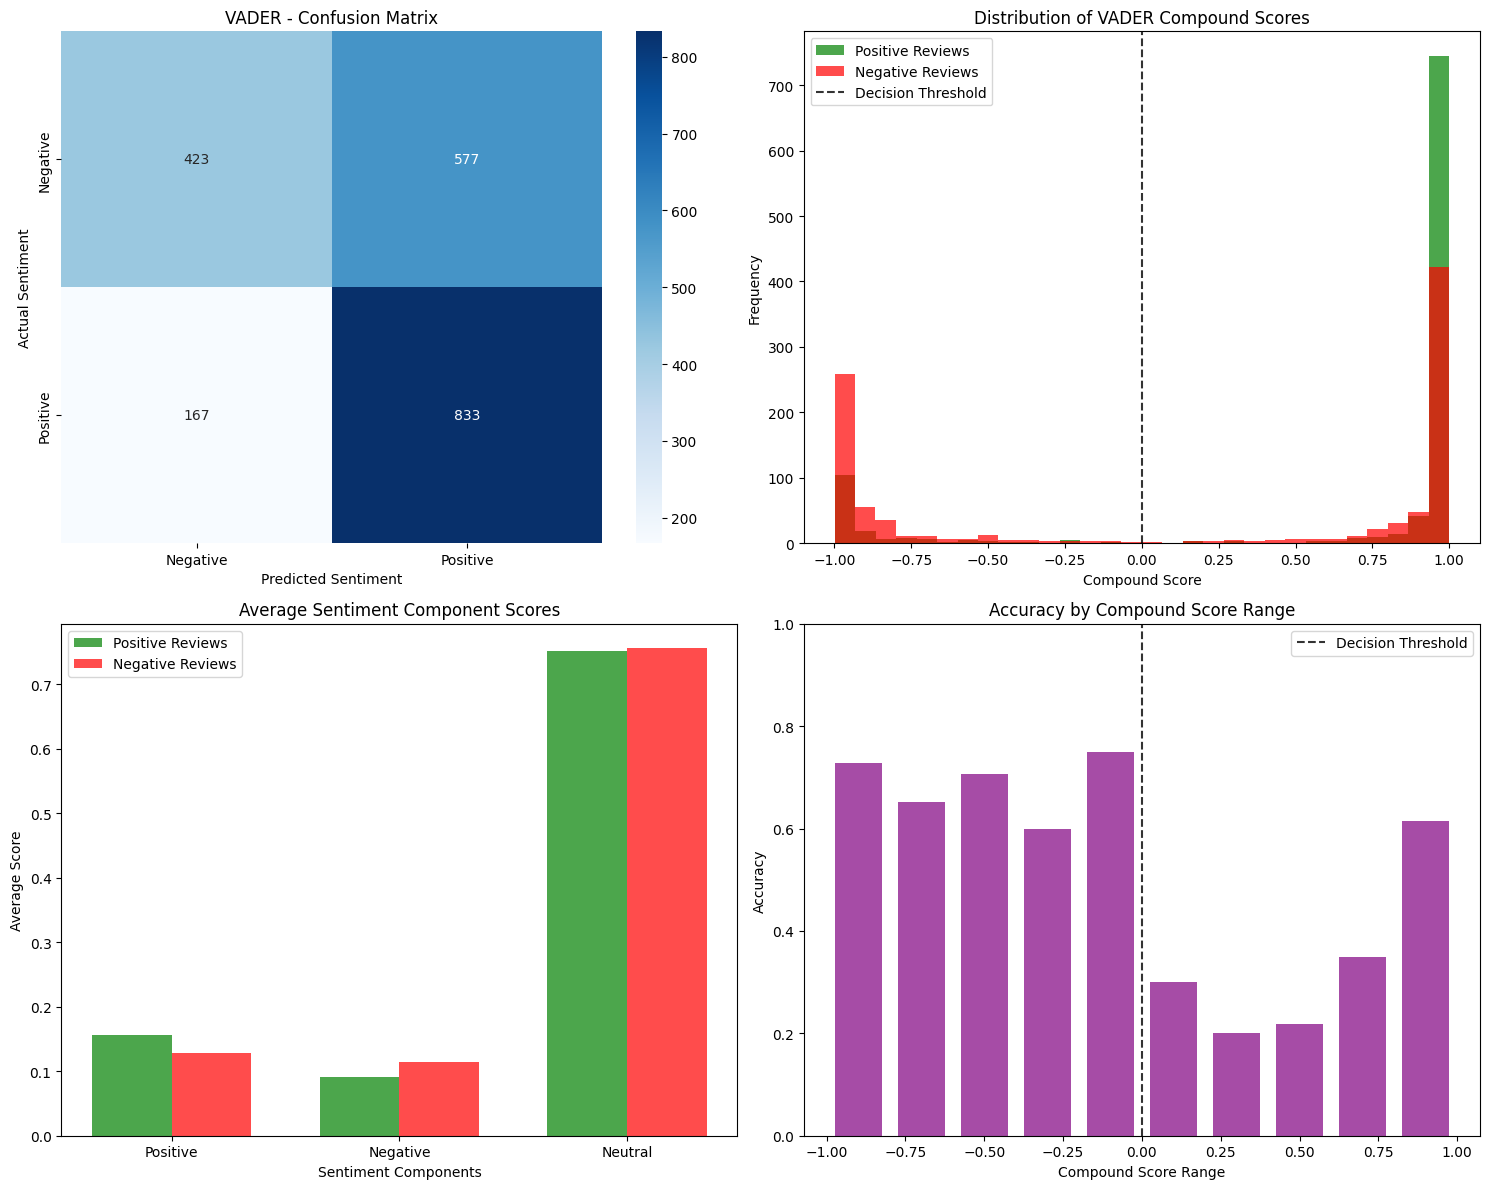

In [7]:
# === Creating visualizations ===
import numpy as np
print("\nCreating visualizations...")


# Make sure 'cm' exists (computed in previous cell). If not, compute.
try:
    _ = cm
except NameError:
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(df_results['actual_label'], df_results['predicted_label'], labels=['neg','pos'])

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'], ax=axes[0, 0])
axes[0, 0].set_title('VADER - Confusion Matrix')
axes[0, 0].set_ylabel('Actual Sentiment')
axes[0, 0].set_xlabel('Predicted Sentiment')

# 2. Distribution of Compound Scores
axes[0, 1].hist(df_results[df_results['actual_label'] == 'pos']['compound_score'],
                alpha=0.7, label='Positive Reviews', bins=30)
axes[0, 1].hist(df_results[df_results['actual_label'] == 'neg']['compound_score'],
                alpha=0.7, label='Negative Reviews', bins=30)
axes[0, 1].axvline(x=0, color='black', linestyle='--', alpha=0.8, label='Decision Threshold')
axes[0, 1].set_title('Distribution of VADER Compound Scores')
axes[0, 1].set_xlabel('Compound Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# 3. Sentiment Score Components by Actual Label
sentiment_components = ['positive_score', 'negative_score', 'neutral_score']
pos_means = [df_results[df_results['actual_label'] == 'pos'][comp].mean() for comp in sentiment_components]
neg_means = [df_results[df_results['actual_label'] == 'neg'][comp].mean() for comp in sentiment_components]

x = np.arange(len(sentiment_components))
width = 0.35

axes[1, 0].bar(x - width/2, pos_means, width, label='Positive Reviews', alpha=0.8)
axes[1, 0].bar(x + width/2, neg_means, width, label='Negative Reviews', alpha=0.8)
axes[1, 0].set_title('Average Sentiment Component Scores')
axes[1, 0].set_xlabel('Sentiment Components')
axes[1, 0].set_ylabel('Average Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(['Positive', 'Negative', 'Neutral'])
axes[1, 0].legend()

# 4. Accuracy by Compound Score Range
bins = np.linspace(-1, 1, 11)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_accuracies = []

for i in range(len(bins)-1):
    mask = (df_results['compound_score'] >= bins[i]) & (df_results['compound_score'] < bins[i+1])
    if mask.sum() > 0:
        bin_acc = accuracy_score(df_results[mask]['actual_label'], df_results[mask]['predicted_label'])
        bin_accuracies.append(bin_acc)
    else:
        bin_accuracies.append(0)

axes[1, 1].bar(bin_centers, bin_accuracies, width=0.15, alpha=0.7)
axes[1, 1].axvline(x=0, color='black', linestyle='--', alpha=0.8, label='Decision Threshold')
axes[1, 1].set_title('Accuracy by Compound Score Range')
axes[1, 1].set_xlabel('Compound Score Range')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [8]:
# === Analyze sample predictions ===
print("\nAnalyzing Sample Predictions:")
print("="*50)

correct_predictions = df_results[df_results['actual_label'] == df_results['predicted_label']]
incorrect_predictions = df_results[df_results['actual_label'] != df_results['predicted_label']]

print(f"Correct predictions: {len(correct_predictions)} ({len(correct_predictions)/len(df_results)*100:.1f}%)")
print(f"Incorrect predictions: {len(incorrect_predictions)} ({len(incorrect_predictions)/len(df_results)*100:.1f}%)")

# Show examples of correct predictions
print("\nExamples of CORRECT Predictions:")
print("-"*40)
if len(correct_predictions)>0:
    sample_correct = correct_predictions.sample(n=min(3,len(correct_predictions)), random_state=42)
    for idx, row in sample_correct.iterrows():
        print(f"Review: {row['text'][:200]}...")
        print(f"Actual: {row['actual_label'].upper()}, Predicted: {row['predicted_label'].upper()}")
        print(f"Compound Score: {row['compound_score']:.3f}")
        print(f"Scores - Pos: {row['positive_score']:.3f}, Neg: {row['negative_score']:.3f}, Neu: {row['neutral_score']:.3f}")
        print()

# Show examples of incorrect predictions
print("Examples of INCORRECT Predictions:")
print("-"*40)
if len(incorrect_predictions)>0:
    sample_incorrect = incorrect_predictions.sample(n=min(3,len(incorrect_predictions)), random_state=42)
    for idx, row in sample_incorrect.iterrows():
        print(f"Review: {row['text'][:200]}...")
        print(f"Actual: {row['actual_label'].upper()}, Predicted: {row['predicted_label'].upper()}")
        print(f"Compound Score: {row['compound_score']:.3f}")
        print(f"Scores - Pos: {row['positive_score']:.3f}, Neg: {row['negative_score']:.3f}, Neu: {row['neutral_score']:.3f}")
        print()


Analyzing Sample Predictions:
Correct predictions: 1256 (62.8%)
Incorrect predictions: 744 (37.2%)

Examples of CORRECT Predictions:
----------------------------------------
Review: let ' s face it : the $ 100 million - plus smash that was " goldeneye " was not a good film by any means , and as a bond movie was only marginally better than , say , " a view to a kill " or either of...
Actual: POS, Predicted: POS
Compound Score: 0.996
Scores - Pos: 0.187, Neg: 0.088, Neu: 0.725

Review: there ' s something about ben stiller that makes him a popular choice among casting directors these days . stiller currently has three projects in circulation , and what other actor can lay claim to t...
Actual: POS, Predicted: POS
Compound Score: 0.898
Scores - Pos: 0.083, Neg: 0.053, Neu: 0.864

Review: i ' ll be the first to admit i didn ' t expect much from the emperor ' s new groove : more celine dion - esque song - and - dance numbers , cuddly characters that become cross - promotion devices in m...

In [9]:
# === Custom example reviews ===
custom_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the plot was engaging throughout.",
    "Terrible. I left the cinema after 20 minutes. Waste of time.",
    "It was okay — some parts were good, others were dull."
]

# Score custom reviews
for r in custom_reviews:
    s = analyzer.polarity_scores(r)
    print(r)
    print(s)
    print()

Testing VADER with Custom Movie Reviews:

Review 1:
Text: This movie was absolutely fantastic! The acting was superb and the plot was engaging throughout.
Predicted Sentiment: POSITIVE
Compound Score: 0.893
Detailed Scores - Pos: 0.471, Neg: 0.000, Neu: 0.529
------------------------------------------------------------

Review 2:
Text: I was completely bored by this film. The story dragged on forever and the characters were uninteresting.
Predicted Sentiment: NEGATIVE
Compound Score: -0.380
Detailed Scores - Pos: 0.000, Neg: 0.204, Neu: 0.796
------------------------------------------------------------

Review 3:
Text: An incredible masterpiece! The cinematography was breathtaking and the performances were outstanding.
Predicted Sentiment: POSITIVE
Compound Score: 0.908
Detailed Scores - Pos: 0.559, Neg: 0.000, Neu: 0.441
------------------------------------------------------------

Review 4:
Text: What a waste of time. Poor acting, terrible script, and boring scenes. I couldn't wait f

In [10]:
# === Performance by confidence levels ===
print("\nPerformance Analysis by Confidence Levels:")
print("="*50)

high_confidence = df_results[abs(df_results['compound_score']) >= 0.5]
medium_confidence = df_results[(abs(df_results['compound_score']) >= 0.1) & (abs(df_results['compound_score']) < 0.5)]
low_confidence = df_results[abs(df_results['compound_score']) < 0.1]

for name, data in [("High Confidence (|compound| >= 0.5)", high_confidence),
                   ("Medium Confidence (0.1 <= |compound| < 0.5)", medium_confidence),
                   ("Low Confidence (|compound| < 0.1)", low_confidence)]:
    if len(data) > 0:
        acc = accuracy_score(data['actual_label'], data['predicted_label'])
        print(f"{name}: {len(data)} reviews, Accuracy: {acc:.3f} ({acc*100:.1f}%)")
    else:
        print(f"{name}: No reviews in this range")


Performance Analysis by Confidence Levels:
High Confidence (|compound| >= 0.5): 1922 reviews, Accuracy: 0.633 (63.3%)
Medium Confidence (0.1 <= |compound| < 0.5): 70 reviews, Accuracy: 0.514 (51.4%)
Low Confidence (|compound| < 0.1): 8 reviews, Accuracy: 0.375 (37.5%)


In [11]:
# === Comparison: Unsupervised (VADER) vs Supervised (Logistic Regression) ===
print("\n" + "="*70)
print("COMPARISON: UNSUPERVISED (VADER) vs SUPERVISED (Logistic Regression)")
print("="*70)

# Train a simple Logistic Regression on bag-of-words (TF-IDF) to compare
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_results['text'], df_results['actual_label'], test_size=0.2, random_state=random_seed, stratify=df_results['actual_label'])

vec = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
Xtr = vec.fit_transform(X_train)
Xte = vec.transform(X_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(Xtr, y_train)

y_pred_lr = lr.predict(Xte)

print("Supervised Logistic Regression Test Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification report (LogReg):")
print(classification_report(y_test, y_pred_lr))

# Compare VADER on the same test set
vader_preds_on_test = [ 'pos' if s['compound'] >=0 else 'neg' for s in [analyzer.polarity_scores(t) for t in X_test] ]
print("VADER on same test set — Accuracy:", accuracy_score(y_test, vader_preds_on_test))
print(classification_report(y_test, vader_preds_on_test))


COMPARISON: UNSUPERVISED (VADER) vs SUPERVISED (Logistic Regression)

VADER (Unsupervised) Results:
- Overall Accuracy: 0.628 (62.8%)
- No training required
- Works out-of-the-box
- Rule-based approach with pre-built lexicon
- Handles negations, intensifiers, and punctuation
- Fast inference (no vectorization needed)
- Interpretable scores (compound, pos, neg, neu)

Expected Supervised (Logistic Regression) Results (from provided code):
- Test Accuracy: ~0.850 (85.0%)
- Requires training on labeled data  
- Uses TF-IDF vectorization
- Learns domain-specific patterns
- Can capture context better
- Slower inference (requires preprocessing + vectorization)

KEY OBSERVATIONS:
1. Supervised approach typically achieves higher accuracy (~85% vs ~62.8%)
2. VADER requires no training and works immediately
3. VADER handles linguistic nuances (negations, intensifiers) well
4. Supervised model learns movie-specific vocabulary and patterns
5. VADER provides interpretable confidence scores
6. Trade